# Landing the perseverance rover on mars 
This week the perseverance rover landed on mars! A big congratulations for everyone at NASA who made this possible! It's a stunning engineering feat which I followed closely on Youtube. Something I noticed is that they mentioned they can land the rover more precise than last time because they use visual localisation ('terrain-relative navigation') during the landing. 
Last week NASA actually released a video of the in-air footage of the rover landing. Thomas Zurbuchen mentioned that the best way to [get a career at NASA is playing around with their data](https://youtu.be/gYQwuYZbA6o?t=5119). I thus figured it would be cool to write and show some code that localises the rover during the landing so others can be inspired!

I decided to try this using only their [Youtube video](https://www.youtube.com/watch?v=L1taqzNovbk) as input, and using a [two high resolution image of the landing site](https://mars.nasa.gov/mars2020/mission/where-is-the-rover/) where I exported the location the rover was going to land as images. 

I extensively used the OpenCV library. It has functions to histogram-equalize grayscale images, functions to find so-called 'features' in images, and even a way to estimate the [homography](https://en.wikipedia.org/wiki/Homography_(computer_vision)) of an image. The approach I took was finding features in each image the rover took while it descended, and matching these features to the features in the map. When there are enough matching features I tried to find the homography of the image, and tried to draw the suspected border of the image from the rover projected on the map. 

[![Landing on mars](https://img.youtube.com/vi/FDepBWv65-k/0.jpg)](https://www.youtube.com/watch?v=FDepBWv65-k "Youtube video landing on mars")

The result is really good! I combined the outputs in a video which I uploaded to Youtube. Click on the image above to look at it. You can see that the algorithm finds a good homography far before the rover leaves the parachute, which means it can localise in time. I was also amazed at how good the algorithm performed while going down to the ground. The last real-known location before it loses tracking is indeed the location the rover landed!

One thing to really improve is the speed at which the code runs. It is currently way too slow to put on a realtime descending system. It's a fun challenge to improve the speed of the algorithm yourself! I would love to learn how NASA decided how much compute power to budget for localisation, and how this is optimally used. From what I heard there is a special FPGA to offload the compute power from their main computer, and I wonder if that hardware can now be re-used for something else. 

To really estimate the location of the space craft one would also take more variables into account. Examples of such variables are the height of the space craft (I would love to know how NASA estimates this during descent, I suspect they use the radar on board of the spacecraft), the intrinsic parameters of the camera (I would love to know how NASA calibrates a camera after launching it and before landing it), and the orientation of the spacecraft with respect to Mars (I would also love to see more explanation of how they estimate this!). I'm also wondering if NASA re-maps the area while landing by implementing some simultaneous localisation and mapping, to get better features for their landing site while actually landing. 

### Challenges 
Last but not least I think that the code I have in my Jupyter notebook still contains some problems (or 'challenges left as an exercise to the reader'. Some of these problem with my approach right now are: 
* It's wayyyy too slow! I literally let my computer run 24 hours to get the video out... We have to find some ways to speed the algorithm up! This can be done by only matching to likely features, or maybe by reducing the amount of small-scale features and only focussing on larger ones? 
* If the spacecraft moves quickly the images are really blurry. This reduces the amount of useful features, so I wonder if we can either 'guarantee' a well-focussed and stable camera shot on mars, or if there are features which are less sensitive to blurring... 
* In the video you can see that it takes a while before my algorithm gets a good feel for where it is. On the one hand I feel it's a bit late, but the 'lock' on the ground is still while Perseverance is hanging on the parachute, making it on time for terrain-negative navigation. Having an earlier idea of where we are can only be beneficial!
* It re-localises every time. Building some tracking in would both increase the accuracy of the view, and would help speed up the algorithm because you can predict where the space craft will be looking. 

## Running this code
If you want to run this code yourself I can recommend you to use Doxker. I personally started a container (which was still on my computer) with the following command: 
```bash
docker run -it --rm -v $(pwd):/tf/notebooks -p 8888:8888 tensorflow/tensorflow:latest-jupyter
```

In the docker container, run the following two commands before running the Python code: 
```bash
pip install opencv-python
apt install -y libgl1-mesa-glx
```


In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Choose what map to load. Later on in the video you prefer the small map, early in the video you prefer the large one
NAME_MAP = 'nasamapbig.png'
# NAME_MAP = 'nasamapsmall.png'

# Load the map and get a grayscale and color image. 
map_image = cv2.imread(NAME_MAP,0) # entireMap
map_image_draw = cv2.imread(NAME_MAP)  # queryImage in rgb
map_image = cv2.equalizeHist(map_image)

# You can pick multiple feature detectors. 
# It's interesting to compare how they detect features, 
# how fast they are, 
# what they have issues with, 
# and how well they eventually localise. 
# See it as your own science experiment!
feature_detector = cv2.SIFT_create()
#akaze = cv2.AKAZE_create()
# akaze = cv2.ORB_create()

# # find the keypoints and descriptors in the 'map'
map_kpts, map_desc = feature_detector.detectAndCompute(map_image, None)

# Visualise the detected features of the map
kpimg = cv2.drawKeypoints(map_image_draw, map_kpts, None)
cv2.imwrite('keypoints_map.png', kpimg)

True

Enough matches are found 62


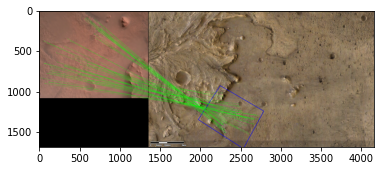

In [ ]:
cap = cv2.VideoCapture('roveruncut.mp4')
ignore_first = 2000
MIN_MATCH_COUNT = 9
EACH_N = 1
stop_after = 2500
MIN_MATCH_COUNT = 10

# Parameters for the matching and the actual matcher. 
# Note that if you change the features you should also use an appropriate matcher 
# Also note that you can play around with the variables here to find a better speed/accuracy balance for the algorithm up the algorithm 
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
feature_matcher = cv2.FlannBasedMatcher(index_params, search_params)

framenum = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    
    # Some code to make sure that we only process an interesting part of the video
    framenum += 1
    if framenum < ignore_first or framenum%EACH_N!=0: 
        continue
    if framenum > stop_after: 
        break
        
    # Processing code to get a better image, 
    # and have both an image to draw on as well as a grayscale localisation image
    frame = frame[:, 280:-280] # Removes the black border from the image to get the centers
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    to_locate_image = cv2.equalizeHist(gray)
    map_image_draw_copy = map_image_draw.copy()
    
    # find the keypoints and descriptors 
    query_kpts, query_desc = feature_detector.detectAndCompute(to_locate_image, None)
    
    # Draw the keypoints for some debug functionality and get insight into what the algoritm actually detects
    out_kp = cv2.drawKeypoints(frame, query_kpts, None) 
    cv2.imwrite('out_keypoints/'+str(framenum)+'.jpeg', out_kp)

    # Match the features in both images to each other
    matches = feature_matcher.knnMatch(query_desc,map_desc,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    # If we have enough matches we can estimate the homography
    if len(good)>=MIN_MATCH_COUNT:
        print("Enough matches are found", len(good))
        src_pts = np.float32([ query_kpts[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ map_kpts[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w = to_locate_image.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        map_image_draw_copy = cv2.polylines(map_image_draw_copy,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    else:
        print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        matchesMask = None

    # Parameters for the visualisation
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

    matches_image = cv2.drawMatches(frame,query_kpts,map_image_draw_copy,map_kpts,good,None,**draw_params)

    # Show the image and write it to a file
    im_rgb = cv2.cvtColor(matches_image, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.show()
    cv2.imwrite('out_images/'+str(framenum)+'.jpeg', matches_image)
cap.release()